# 目的
- エンゼルの出現確率を予測する
- 事前分布にβ分布を用いたバージョン

In [1]:
import sys, os
import sqlite3
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from datetime import datetime as dt

import pymc as pm
import scipy.stats as stats


# データの取得
- データはDB（sqlite）に保存されている
    - テーブル定義は、ブログに載っている通り

In [2]:
def get_data(db_file='../data/choco-ball.db', table_name='measurement', filter_str=None):
    """
    dbファイルから計測データを取得する
    
    TODO:
        エラー処理を入れる
    """
    con = sqlite3.connect(db_file)
    sql = 'SELECT '
    sql += 'measure_date,best_before,prd_number,weight,box_weight,ball_number,factory,shop,angel,campaign,taste '
    sql += ', (weight - box_weight), (weight - box_weight)/ball_number '
    sql += 'FROM ' + table_name + ' '
    if filter_str is not None:
        sql += 'WHERE ' + filter_str
    sql += ';'
    sql_result = con.execute(sql)
    res = sql_result.fetchall()
    con.close()
    data = pd.DataFrame(res, columns=['measure_date','best_before','prd_number','weight','box_weight','ball_number','factory','shop','angel','campaign','taste','net_weight','mean_weight'])
    print 'Shape of MeasurementData(record_num, n_columns) : {}'.format(data.shape)
    return data
data = get_data(filter_str='campaign=1')

Shape of MeasurementData(record_num, n_columns) : (85, 13)


# エンゼル出現確率予測
## 最尤推定

In [3]:
# 最尤推定量
data_angel = data['angel'].values
p_MLE = data_angel.mean()
print 'angel rate(freq):%.3f'%(p_MLE)

angel rate(freq):0.024


## ベイズ推定

### モデル
- データ過程：ベルヌーイ分布（確率pで事象が発生し、(1-p)で発生しない）
- 事前分布：一様分布（0~1の実数を取る分布）

In [6]:
data_angel = data_angel[:75]
data_angel.shape

(75,)

In [7]:
# 出現確率pの事前分布
p = pm.Beta('p', alpha=1, beta=1)
#p = pm.Uniform('p', lower=0, upper=1)
# 観測を結びつける
obs = pm.Bernoulli('obs', p, value=data_angel, observed=True)

# MCMC
# Modelオブジェクト生成
model = pm.Model([p, obs])
mcmc = pm.MCMC(model)
mcmc.sample(15000, 5000)

 [-----------------100%-----------------] 15000 of 15000 complete in 0.7 sec

Text(0.5,1,u'observation number = 75')

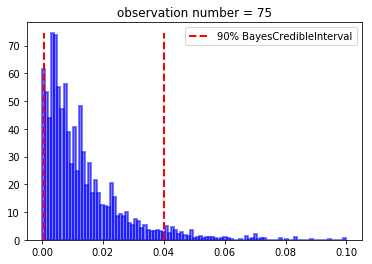

In [8]:
p_trace = mcmc.trace('p')[:]
ret = plt.hist(p_trace, bins=np.linspace(0, 0.1, 100), normed=True,
               color="#0000FF", alpha=0.5, edgecolor="#0000FF", lw=2)
#plt.xlim([0, 0.5])
N = len(p_trace)
bci_g = np.sort(p_trace)[int(N * 0.95)]
bci_l = np.sort(p_trace)[int(N * 0.05)]
plt.vlines(x=bci_g, ymin=0, ymax=ret[0].max(),
           label='90% BayesCredibleInterval',
           color='red', linestyles='--', linewidths=2)
plt.vlines(x=bci_l, ymin=0, ymax=ret[0].max(),
           color='red', linestyles='--', linewidths=2)
plt.legend(loc="upper right")
plt.title('observation number = %d' % (len(data_angel)))


In [9]:
print p_trace.mean()

0.0129325642891


### 事前分布に先人の知恵を導入
- 「チョコボール 確率 金」で検索してヒットしたブログを集計し、事前分布を出す
- [【1,000箱目】森永チョコボール 金・銀のエンゼルが出る確率を出す(鳥取の社長日記)](http://blog.livedoor.jp/remsy/archives/51931218.html)
    - 1000箱で１個（銀は1000箱で36個）
- [ヒカルが検証！　チョコボールで金のエンゼルが当たる確率は？（YouTuberのネタ宝庫　アイデア＆アイテム集結）](http://www.youtuber-item.com/entry/2017/01/19/212219)
    - 有名Youtuberさんが集計した結果を転載するブログ
    - 1000箱で2個（銀は1000箱で40個）
- [９１５分の１って！「月曜から夜ふかし」が金のエンゼルが出る確率を検証した結果](http://mystock-abc.xyz/?p=476)
    - テレビ番組の企画での集計
    - 915箱で1個
- 全ての期間、味でエンゼルの出現確率が一定であると仮定する
    - (1+2+1)/(1000+1000+915)=4/2915=0.0014(0.14%)

β分布の期待値=a/(a+b)

In [ ]:
x = np.linspace(0.0, 0.999, 1000)
y = stats.beta.pdf(x, 4, 2911)
plt.plot(x, y)
pd.DataFrame({'x':x, 'y':y}).sort_values(by=['y'], ascending=False)[:3]

In [ ]:
# 出現確率pの事前分布
p = pm.Beta('p', alpha=4, beta=2915)
# 観測を結びつける
obs = pm.Bernoulli('obs', p, value=data_angel, observed=True)

# MCMC
# Modelオブジェクト生成
model = pm.Model([p, obs])
mcmc = pm.MCMC(model)
mcmc.sample(15000, 5000)

In [ ]:
p_trace = mcmc.trace('p')[:]
ret = plt.hist(p_trace, bins=np.linspace(0, 0.01, 100), normed=True, 
               color="#0000FF", alpha=0.5, edgecolor="#0000FF", lw=2)
plt.vlines(x=0.0014, ymin=0, ymax=ret[0].max(), 
           colors='#FF0000', linewidths=2, label='prior') # 初期分布の最大値

N = len(p_trace)
bci_g = np.sort(p_trace)[int(N * 0.95)]
bci_l = np.sort(p_trace)[int(N * 0.05)]
plt.vlines(x=bci_g, ymin=0, ymax=ret[0].max(),
           label='90% BayesCredibleInterval',
           color='red', linestyles='--', linewidths=2)
plt.vlines(x=bci_l, ymin=0, ymax=ret[0].max(),
           color='red', linestyles='--', linewidths=2)
plt.legend(loc="upper right")

print 'estimated p : {}'.format(p_trace.mean())

In [ ]:
# 確率pで成功する事象がk回の試行で成功する確率 → 幾何分布
z = np.random.geometric(p=0.0014, size=10000)
plt.hist(z)

In [ ]:
from scipy.stats import geom
fig, ax = plt.subplots(1, 1)
p = 0.001

x = np.arange(geom.ppf(0.01, p),
              geom.ppf(0.99, p))
ax.plot(x, geom.pmf(x, p), 'bo', ms=8, label='geom pmf')
ax.vlines(x, 0, geom.pmf(x, p), colors='b', lw=5, alpha=0.5)

rv = geom(p)
ax.vlines(x, 0, rv.pmf(x), colors='k', linestyles='-', lw=1,
          label='frozen pmf')
ax.legend(loc='best', frameon=False)
plt.show()

In [ ]:
p = 0.1
x = np.linspace(1, 100)
plt.plot(x, geom.pmf(x, p))

In [ ]:
ret = plt.hist(geom.rvs(p=0.001, size=1000), bins=100)

In [ ]:
x = np.linspace(1, 5000)
plt.plot(x, geom.cdf(k=x, p=0.001))